# Pairing image

In [1]:
import os
import random
import shutil
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import cv2

## Merge train and test set from original dataset

### Paths

In [2]:
# Define paths
real_test_path = r"D:\Sketchy\Sketchy\real_test"
real_train_path = r"D:\Sketchy\Sketchy\real_train"
real_path = r"D:\Sketchy\Sketchy\real"

# Create the real directory if it doesn't exist
os.makedirs(real_path, exist_ok=True)

### Merging

In [3]:
test_subfolders = set(os.listdir(real_test_path))
train_subfolders = set(os.listdir(real_train_path))

# Merge subfolders
all_subfolders = test_subfolders.union(train_subfolders)

for subfolder in all_subfolders:
    # Create subfolder in the real directory
    real_subfolder_path = os.path.join(real_path, subfolder)
    os.makedirs(real_subfolder_path, exist_ok=True)

    # Copy files from real_test to real
    test_subfolder_path = os.path.join(real_test_path, subfolder)
    if os.path.exists(test_subfolder_path):
        for file_name in os.listdir(test_subfolder_path):
            shutil.copy(os.path.join(test_subfolder_path, file_name), real_subfolder_path)

    # Copy files from real_train to real
    train_subfolder_path = os.path.join(real_train_path, subfolder)
    if os.path.exists(train_subfolder_path):
        for file_name in os.listdir(train_subfolder_path):
            shutil.copy(os.path.join(train_subfolder_path, file_name), real_subfolder_path)

print("Merge complete!")


Merge complete!


# Imange processing

Ảnh real hiện tại đang là RGB, cần sang trắng đen để thể hiện tinh thần tranh sketch

Giải thích những vấn đề với ảnh real hiện tại (demo ảnh random nếu chỉ invert grayscale)

demo với edge enhancer và sử dụng weigh scaling để tăng vùng ảnh ( có thẻ cho dùng edge enhancer rồi so sánh output RGB và trắng đen để so sánh hiệu quả weight scaling)

### Randomize set of images

In [10]:
def get_images_by_category(real_path):
    """
    Retrieve all subfolders and images in the given real path.

    Args:
        real_path (str): The root directory containing subfolders with images.

    Returns:
        dict: A dictionary with subfolder names as keys and lists of image file names as values.
    """
    data = {}
    for subfolder in os.listdir(real_path):
        subfolder_path = os.path.join(real_path, subfolder)
        if os.path.isdir(subfolder_path):
            # List all files in the subfolder
            images = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
            data[subfolder] = images
    return data

image_data = get_images_by_category(real_path)


def random_image_picker(data):
    """
    Pick a random image from the dictionary.

    Args:
        data (dict): Dictionary containing subfolder names and their images.

    Returns:
        tuple: Subfolder name and randomly selected image file name.
    """
    subfolder = random.choice(list(data.keys()))  # Randomly select a subfolder
    if data[subfolder]:
        image = random.choice(data[subfolder])  # Randomly select an image from the subfolder
        return subfolder, image
    else:
        return subfolder, None

# Example usage
picked_subfolder, picked_image = random_image_picker(image_data)
print(f"Randomly picked image: {picked_image} from category: {picked_subfolder}")


Randomly picked image: n07753592_16139.png from category: banana


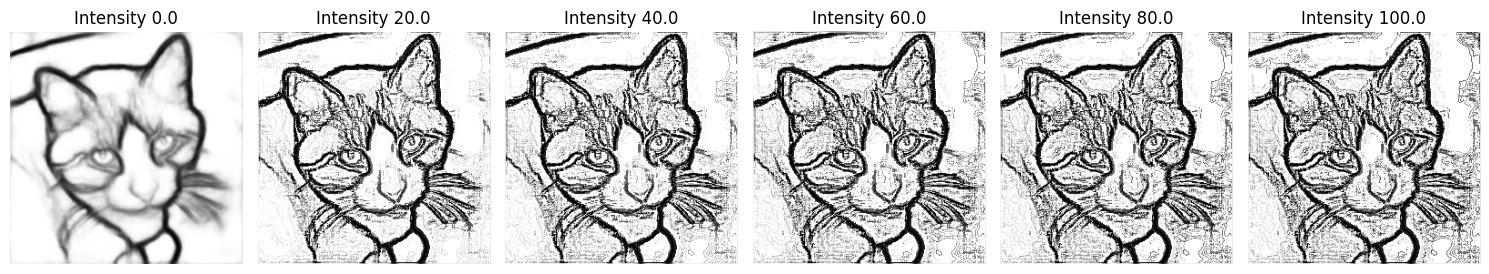

In [3]:
# Load the sketch
image_path = r"D:\Sketchy\Sketchy\real\cat\n02121620_531.png"
img = Image.open(image_path)

# Function to enhance edges and emphasize light colors
def enhance_light_edges(image, intensity=1.0, color_weight=(0.3, 0.59, 0.11)):
    """
    Enhance edges and emphasize light-colored edges.
    
    Args:
        image (PIL.Image): Input RGB image.
        intensity (float): Intensity of edge enhancement.
        color_weight (tuple): Weights for RGB channels in greyscale conversion.
    
    Returns:
        PIL.Image: Processed image with enhanced light edges.
    """
    # Apply edge enhancement filter
    edge_enhanced = image.filter(ImageFilter.EDGE_ENHANCE_MORE)
    
    # Blend the original and enhanced images reald on intensity
    enhanced_image = Image.blend(image, edge_enhanced, alpha=intensity)
    
    # Emphasize light-colored edges by converting to greyscale with custom weights
    enhanced_array = np.array(enhanced_image)
    greyscale_array = (
        enhanced_array[:, :, 0] * color_weight[0] +
        enhanced_array[:, :, 1] * color_weight[1] +
        enhanced_array[:, :, 2] * color_weight[2]
    ).astype(np.uint8)
    
    # Invert the greyscale image for better contrast
    inverted_array = 255 - greyscale_array
    enhanced_image = Image.fromarray(inverted_array)
    return enhanced_image

# Visualization parameters
s, e, step = 0, 100, 20  # Start, end, and step for intensity
intensities = np.arange(s, e + step, step)  # Generate intensity range

# Plot results
plt.figure(figsize=(15, 5))

for i, intensity in enumerate(intensities, 1):
    enhanced_img = enhance_light_edges(img, intensity=intensity, color_weight=(0.3, 0.59,0.11))
    plt.subplot(1, len(intensities), i)
    plt.imshow(enhanced_img, cmap='gray')
    plt.title(f"Intensity {intensity:.1f}")
    plt.axis("off")


plt.tight_layout()
plt.show()


# GreyScale all real images edges

In [ ]:
# Define paths
processed_path = r"D:\Sketchy\Sketchy\real_processed"

# Function to process all images in subfolders
def process_images(real_path, processed_path, intensity=1.0, color_weight=(0.3, 0.59, 0.11)):
    """
    Process all images in the real_path directory and save to processed_path.

    Args:
        real_path (str): Path to the input images directory.
        processed_path (str): Path to save processed images.
        intensity (float): Intensity of edge enhancement.
        color_weight (tuple): Weights for RGB channels in greyscale conversion.
    """
    for subfolder in os.listdir(real_path):
        subfolder_path = os.path.join(real_path, subfolder)
        if os.path.isdir(subfolder_path):  # Ensure it's a folder
            # Create corresponding subfolder in processed_path
            processed_subfolder = os.path.join(processed_path, subfolder)
            os.makedirs(processed_subfolder, exist_ok=True)
            
            # Process each image in the subfolder
            for image_name in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_name)
                try:
                    img = Image.open(image_path)
                    processed_img = enhance_light_edges(img, intensity=intensity, color_weight=color_weight)
                    processed_img.save(os.path.join(processed_subfolder, image_name))
                    print(f"Processed: {image_path}")
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

# Run the process
process_images(real_path, processed_path, intensity=100.0, color_weight=(0.3, 0.59, 0.11))


# Define paths
bad_sketches_path = r"D:\Sketchy\Sketchy\sketches"
real_processed_path = r"D:\Sketchy\Sketchy\real_processed"
output_path = r"D:\Sketchy\Sketchy\paired_sketches"

# Function to concatenate two images side by side
def concatenate_images(image1, image2):
    """
    Concatenate two images horizontally.

    Args:
        image1 (PIL.Image): First image.
        image2 (PIL.Image): Second image.

    Returns:
        PIL.Image: Concatenated image.
    """
    # Ensure both images have the same height
    if image1.size[1] != image2.size[1]:
        image2 = image2.resize((image2.size[0], image1.size[1]))
    
    # Create a new blank image with combined width
    new_width = image1.size[0] + image2.size[0]
    combined_image = Image.new('RGB', (new_width, image1.size[1]))
    
    # Paste images side by side
    combined_image.paste(image1, (0, 0))
    combined_image.paste(image2, (image1.size[0], 0))
    
    return combined_image

# Function to process and pair images
def pair_sketches(bad_sketches_path, real_processed_path, output_path):
    """
    Pair bad sketches with corresponding good sketches and save the concatenated results.

    Args:
        bad_sketches_path (str): Path to bad sketches directory.
        real_processed_path (str): Path to real processed sketches directory.
        output_path (str): Path to save paired sketches.
    """
    # Create output directory if not exists
    os.makedirs(output_path, exist_ok=True)
    
    # Iterate through each subfolder in bad_sketches_path
    for subfolder in os.listdir(bad_sketches_path):
        bad_subfolder_path = os.path.join(bad_sketches_path, subfolder)
        real_subfolder_path = os.path.join(real_processed_path, subfolder)
        output_subfolder_path = os.path.join(output_path, subfolder)
        
        if os.path.isdir(bad_subfolder_path) and os.path.isdir(real_subfolder_path):
            # Create corresponding subfolder in output_path
            os.makedirs(output_subfolder_path, exist_ok=True)
            
            # Get real sketch images
            real_images = {os.path.splitext(f)[0]: os.path.join(real_subfolder_path, f) 
                           for f in os.listdir(real_subfolder_path) if f.endswith('.png')}
            
            # Get bad sketches and match with real sketches
            for bad_image_name in os.listdir(bad_subfolder_path):
                if bad_image_name.endswith('.png'):
                    # Extract base name without the suffix (e.g., "-1", "-2")
                    base_name_with_suffix = os.path.splitext(bad_image_name)[0]
                    base_name = base_name_with_suffix.split('-')[0]
                    
                    # Check if corresponding real image exists
                    if base_name in real_images:
                        bad_image_path = os.path.join(bad_subfolder_path, bad_image_name)
                        real_image_path = real_images[base_name]
                        
                        # Load images
                        bad_image = Image.open(bad_image_path)
                        real_image = Image.open(real_image_path)
                        
                        # Concatenate bad sketch and real sketch
                        paired_image = concatenate_images(bad_image, real_image)
                        
                        # Save the paired image
                        paired_image_name = f"{base_name_with_suffix}_paired.png"
                        paired_image.save(os.path.join(output_subfolder_path, paired_image_name))
# Run the function
pair_sketches(bad_sketches_path, real_processed_path, output_path)
